# 2 - Análisis de datos agrícolas

En este ejemplo se analizan datos de los **4 cultivos de exportación principales de la Argentina: soja, girasol, trigo y maíz.**

In [26]:
from __future__ import unicode_literals

import pandas as pd
import numpy as np
import requests
import json
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import HTML

%matplotlib inline
matplotlib.style.use("ggplot")

## 2.1 - Conseguir los datos
El primer paso es armar un conjunto de datos para luego hacer análisis. En este ejemplo vamos a usar dos tipos de fuentes de datos: una **API** y un **Portal de Datos**.

### Portal de Datos Abiertos de Agroindustria 

Descargamos datos de producción, rendimiento, superficie sembrada y cosechada de los 4 cultivos desde el **Portal de Datos Abiertos de Agroindustria**: https://datos.magyp.gob.ar 

El archivo `datos/datos-magyp-cultivos-principales.csv` es una descarga de https://datos.magyp.gob.ar/reportes.php?reporte=Estimaciones eligiendo Soja, Girasol, Trigo y Maíz, a nivel de Departamentos (agregación geográfica).

In [27]:
# si el CSV que se lee no sigue la especificación más estándar (RFC 4180) puede ser necesario
# especificar separador, codificación, separador de miles y caracter decimal
df_cultivos = pd.read_csv("data/datos-magyp-cultivos-principales.csv", 
                          sep=";", encoding="latin1", thousands=".", decimal=",")

In [28]:
df_cultivos.head()

,Cultivo,Campaña,Provincia,Departamento,Sup. Sembrada,Sup. Cosechada,Producción,Rendimiento
0,Girasol,1969/70,BUENOS AIRES,25 de Mayo,30000,30000,22500,750
1,Girasol,1970/71,BUENOS AIRES,25 de Mayo,44000,31000,15000,484
2,Girasol,1971/72,BUENOS AIRES,25 de Mayo,22000,19000,10450,550
3,Girasol,1972/73,BUENOS AIRES,25 de Mayo,20000,5000,5100,1020
4,Girasol,1973/74,BUENOS AIRES,25 de Mayo,14000,14000,10800,771


El archivo `datos/datos-magyp-produccion-estimaciones.csv` es una descarga del dataset completo de estimaciones de producción primaria https://datos.magyp.gob.ar/reportes.php?reporte=Estimaciones (abajo de todo, "Descargar Dataset").

In [29]:
df_estim = pd.read_csv("data/datos-magyp-produccion-estimaciones.csv",
                     sep=";", encoding="latin1", thousands=".", decimal=",")

In [30]:
df_estim.head()

,ID Provincia,Provincia,ID Departamento,Departamento,Id Cultivo,Cultivo,ID Campaña,Campana,Sup. Sembrada (Ha),Sup. Cosechada (Ha),Producción (Tn),Rendimiento (Kg/Ha)
0,6,BUENOS AIRES,854,25 de Mayo,1,Ajo,1,1969/70,3,3,10,3333
1,6,BUENOS AIRES,854,25 de Mayo,1,Ajo,2,1970/71,1,1,3,3000
2,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,1,1969/70,15,15,82,5467
3,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,2,1970/71,10,10,55,5500
4,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,3,1971/72,8,8,44,5500


### COMTRADE
Queremos sumar datos de precios internacionales de estos 4 cultivos a lo largo del tiempo. 

Naciones Unidas recopila datos de comercio exterior de (casi) todos los países del mundo y los disponibiliza en una base de datos llamada **Comtrade**.

Usamos la **API de UN Comtrade** (https://comtrade.un.org/data/doc/api) para descargar montos y cantidades totales exportadas por la Argentina, y así construir un precio promedio por tonelada exportada.

Nota: esta metodología tiene sus más y sus menos, para ver una discusión en mayor detalle sobre el tema ver el jupyter auxiliar **Precios internacionales de cultivos (COMTRADE vs. WB)**.

In [31]:
API_COMTRADE = "http://comtrade.un.org/api/get"

In [32]:
params = {
    "freq": "A", # frecuencia anual
    "r": 32, # reporter (reporta los datos): 32 es el código de la Argentina
    "ps": "ALL", # período (any para tomar todos los años)
    "px": "S1", # sistema de clasificación de productos: SITC Rev 1 es la serie más larga
    "fmt": "JSON", # formato devuelto (CSV o JSON)
    "p": 0, # partner (contraparte comercial del reporter): 0 es el código del Mundo
    "rg": 2, # 1: importaciones, 2: exportaciones
    "cc": "2214,041,4216,044", # commodity code: 2214 "Soya" / 041 "Wheat" / 4216 "Sunflower" / 044 "Corn"
    "max": 50000, # cantidad máxima de resultados (50.000 es un máximo absoluto)
    "head": "H", # M: machine readable headers, H: human readable headers
}

In [33]:
# si internet funciona
# res = requests.get(API_COMTRADE, params=params)
# json_res = res.json()

# si internet no funciona
with open("data/comtrade-cultivos-principales.json", "rb") as f:
    json_res = json.load(f)

Creamos un **DataFrame a partir de un JSON** con la siguiente estructura: `[{}, {}, {}, ...]` donde cada objeto es una fila del dataset.

In [34]:
df_comtrade = pd.DataFrame(json_res["dataset"])

In [35]:
df_comtrade.head(3)

,AltQuantity,CIFValue,FOBValue,GrossWeight,IsLeaf,NetWeight,TradeQuantity,TradeValue,aggrLevel,cmdCode,...,qtAltCode,qtAltDesc,qtCode,qtDesc,rgCode,rgDesc,rt3ISO,rtCode,rtTitle,yr
0,None,None,None,None,0,2832336128,2832336128,173363088,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1962
1,None,None,None,None,0,1830655616,1830655616,116388784,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1963
2,None,None,None,None,0,3710008576,3710008576,242256288,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1964


In [36]:
df_comtrade.head(3).transpose()

,0,1,2
AltQuantity,None,None,None
CIFValue,None,None,None
FOBValue,None,None,None
GrossWeight,None,None,None
IsLeaf,0,0,0
NetWeight,2832336128,1830655616,3710008576
TradeQuantity,2832336128,1830655616,3710008576
TradeValue,173363088,116388784,242256288
aggrLevel,3,3,3
cmdCode,041,041,041


In [37]:
columns = [
    "rgDesc", # descripción del tipo de flujo de comercio (Importación, Exportación, Re-Exportación) ("trade regime")
    "rtTitle", # nombre del país que reporta el flujo de comercio ("reporter")
    "ptTitle", # nombre del país que es contraparte del flujo de comercio reportado ("partner")
    "yr", # año
    "cmdCode", # código de la mercadería ("commodity code")
    "cmdDescE", # descripción de la mercadería ("commodity description")
    "TradeValue", # valor del flujo comercial ("trade value")
    "TradeQuantity", # cantidad física involucrada en el flujo comercial ("trade quantity")
    "qtDesc" # unidad de la cantidad utilizada ("quantity description")
]

In [38]:
df_comtrade[columns].head(5)

,rgDesc,rtTitle,ptTitle,yr,cmdCode,cmdDescE,TradeValue,TradeQuantity,qtDesc
0,Export,Argentina,World,1962,041,"Wheat including spelt and meslin, unmilled",173363088,2832336128,Weight in kilograms
1,Export,Argentina,World,1963,041,"Wheat including spelt and meslin, unmilled",116388784,1830655616,Weight in kilograms
2,Export,Argentina,World,1964,041,"Wheat including spelt and meslin, unmilled",242256288,3710008576,Weight in kilograms
3,Export,Argentina,World,1965,041,"Wheat including spelt and meslin, unmilled",372666400,6660583936,Weight in kilograms
4,Export,Argentina,World,1966,041,"Wheat including spelt and meslin, unmilled",279624704,5054666240,Weight in kilograms


In [39]:
df_comtrade[columns].tail(5)

,rgDesc,rtTitle,ptTitle,yr,cmdCode,cmdDescE,TradeValue,TradeQuantity,qtDesc
202,Export,Argentina,World,2011,4216,Sunflower seed oil,1176553428,908109965,Weight in kilograms
203,Export,Argentina,World,2012,4216,Sunflower seed oil,928531664,790948144,Weight in kilograms
204,Export,Argentina,World,2013,4216,Sunflower seed oil,528181934,447704974,Weight in kilograms
205,Export,Argentina,World,2014,4216,Sunflower seed oil,366774725,349370968,Weight in kilograms
206,Export,Argentina,World,2015,4216,Sunflower seed oil,405056803,439193748,Weight in kilograms


Ahora creamos el campo **"precio de la tonelada exportada"** ("precio_ton") como una división entre "trade value" y "trade quantity".

In [40]:
df_comtrade["precio_ton"] = df_comtrade.TradeValue / df_comtrade.TradeQuantity * 1000

df_precios = df_comtrade.pivot(index='yr', columns='cmdDescE', values='precio_ton')
df_precios.columns = ['Maiz', 'Soja', 'Girasol','Trigo']

In [41]:
df_precios.tail()

,Maiz,Soja,Girasol,Trigo
yr,,,,
2011,286.736868,504.611748,1295.606780,298.504060
2012,271.127216,518.252314,1173.947586,256.266138
2013,291.441014,525.449603,1179.754447,304.016832
2014,221.789213,507.460665,1049.814548,325.886841
2015,187.096364,366.511898,922.273609,239.572116


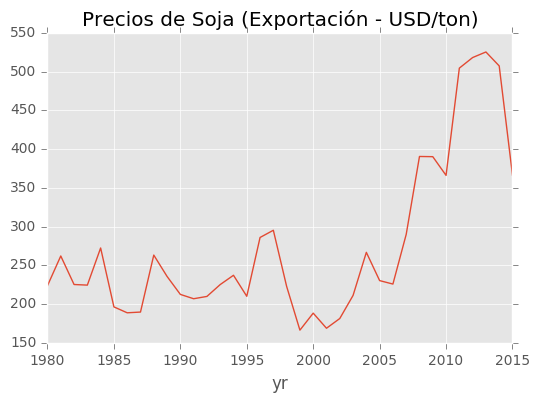

In [42]:
df_precios.Soja[df_precios.Soja.index >= 1980].plot.line(title="Precios de Soja (Exportación - USD/ton)")

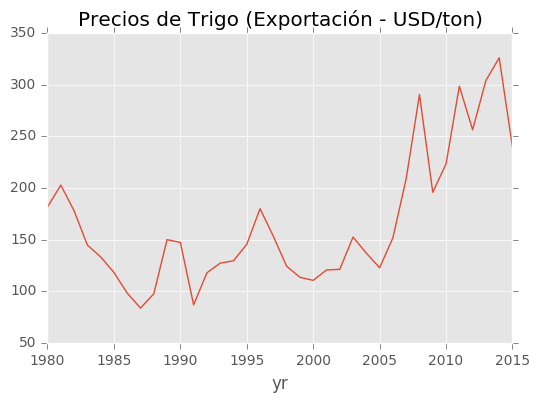

In [43]:
df_precios.Trigo[df_precios.Trigo.index >= 1980].plot.line(title="Precios de Trigo (Exportación - USD/ton)")

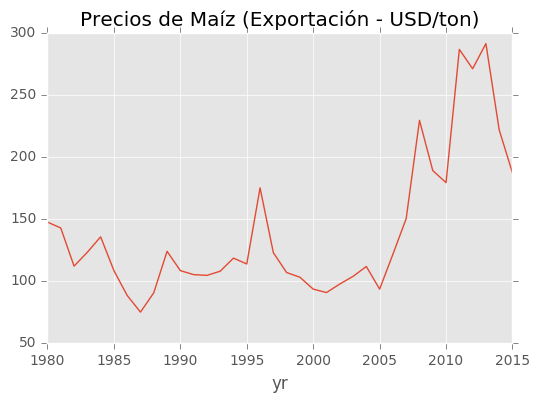

In [44]:
df_precios.Maiz[df_precios.Maiz.index >= 1980].plot.line(title="Precios de Maíz (Exportación - USD/ton)")

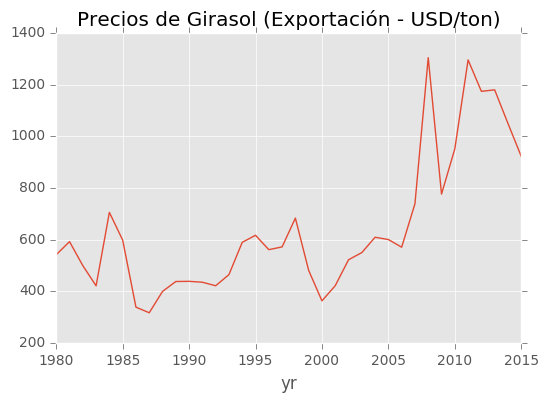

In [45]:
df_precios.Girasol[df_precios.Girasol.index >= 1980].plot.line(title="Precios de Girasol (Exportación - USD/ton)")

## 2.2 Exploración inicial

In [46]:
# Funciones auxiliares

def pivotear_tabla(df, grupo, campo, columnas):
    df_out = df.groupby(grupo)[campo].sum() # Agrupar y sumar
    df_out = df_out.reset_index(level=1) # Volver el cultivo a una columna normal (sacarlo del indice)
    df_out = df_out.pivot(columns=columnas, values=campo) # Pivotear para convertir en un tabla
    df_out.index = df_out.index.str.slice(0,4).astype(int) # Extraer 4 caracteres del indice y convertir a int
    df_out = df_out[['Maiz', 'Soja', 'Girasol','Trigo']]
    return df_out

### Series en el tiempo

#### Precios vs t

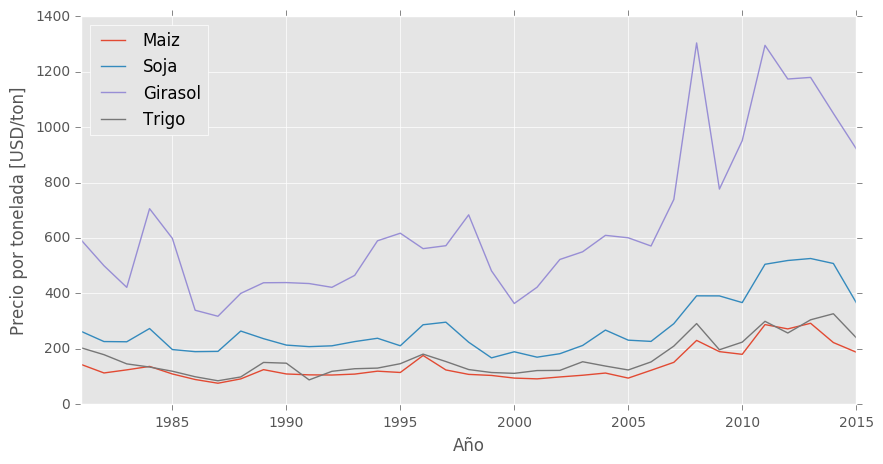

In [47]:
df_precios[df_precios.index > 1980].plot(figsize=(10,5))
plt.xlabel(u"Año")
plt.ylabel(u"Precio por tonelada [USD/ton]")

#### Sup. Total Sembrada vs t

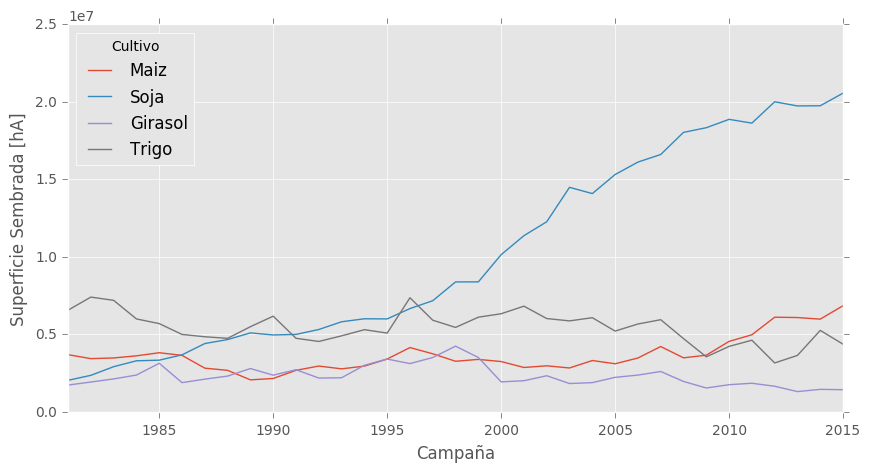

In [48]:
# Agrupar por año

df_sup = pivotear_tabla(df_cultivos, grupo=['Campaña', 'Cultivo'], 
                        campo='Sup. Sembrada',
                        columnas='Cultivo')

df_sup[df_sup.index > 1980].plot(figsize=(10,5))
plt.ylabel(u"Superficie Sembrada [hA]")

#### Rendimiento vs t

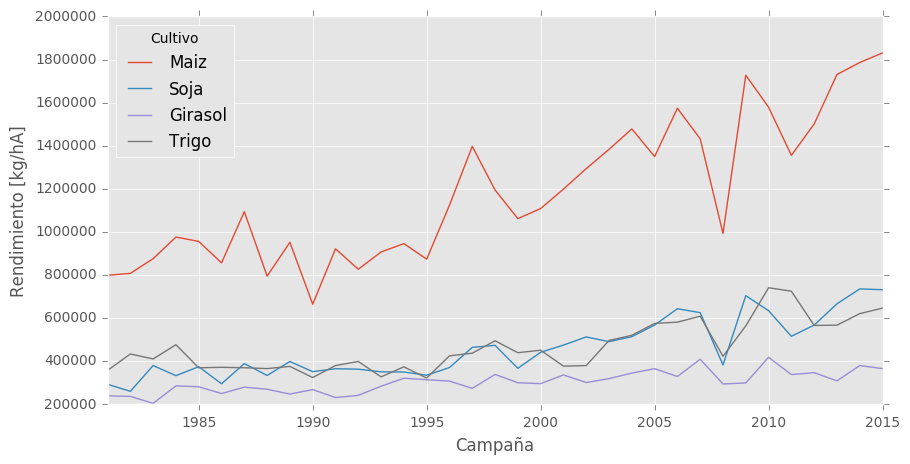

In [49]:
# Agrupar por año

df_ren = pivotear_tabla(df_cultivos,grupo=['Campaña', 'Cultivo'], 
                        campo='Rendimiento',
                        columnas='Cultivo')

df_ren[df_ren.index > 1980].plot(figsize=(10,5))
plt.ylabel(u"Rendimiento [kg/hA]")

##### Detrending del rendimiento

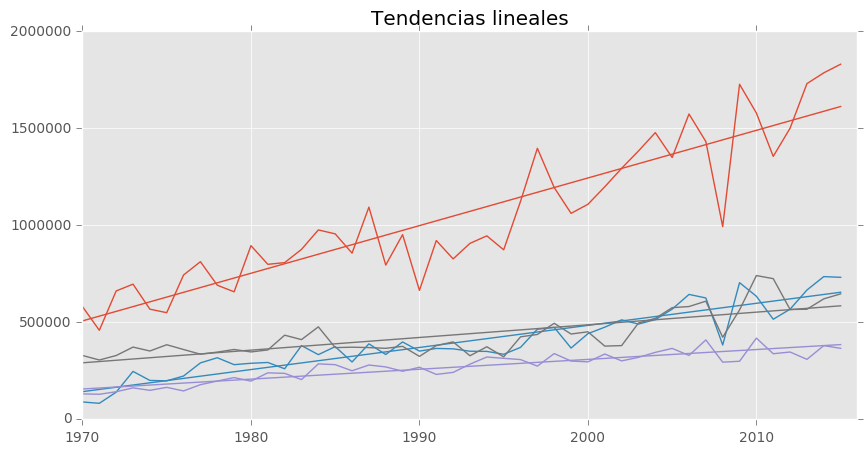

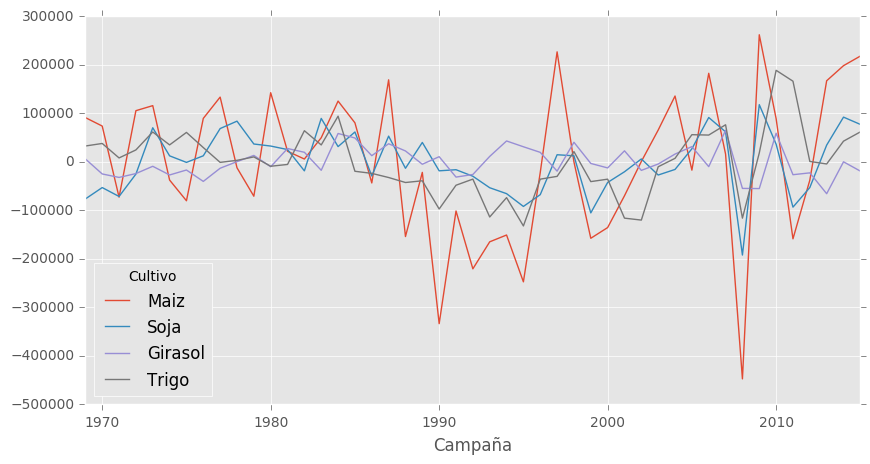

In [50]:
from scipy import signal

x = df_ren.index
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes()

for col in df_ren.columns:
    y = df_ren[col]
    p = np.polyfit(x, y, 1)
    data_plt, = plt.plot(x, y)
    plt.plot(x, np.polyval(p, x.values), color=data_plt.get_color())

plt.title("Tendencias lineales")    
plt.xlim((1970,2016))

df_ren_detrended = pd.DataFrame(signal.detrend(df_ren, axis=0), columns=df_ren.columns, index=df_ren.index)
df_ren_detrended.plot(figsize=(10,5))

#### Rendimientos relativos vs t

Aca los rendimientos estan normalizados al promedio y se ve que siguen crecimiento parecidos.

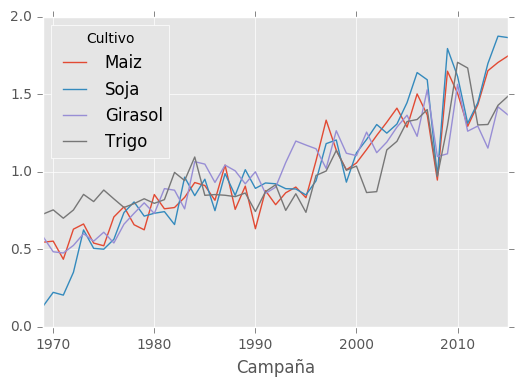

In [51]:
# Tomar valores relativizados al promedio
(df_ren / df_ren.mean(axis=0)).plot()

#### Produccion valuada (escala logaritmica)

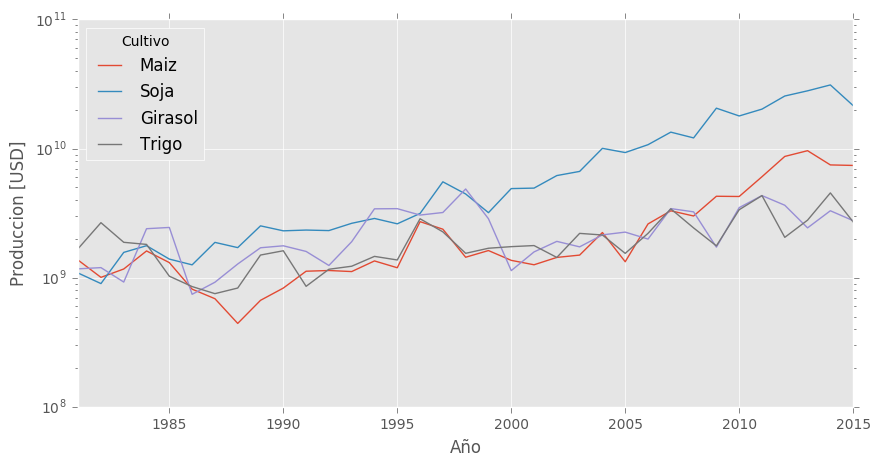

In [52]:
df_prod = pivotear_tabla(df_cultivos, grupo=['Campaña', 'Cultivo'], 
                        campo='Producción',
                        columnas='Cultivo')

df_prod_dolars = df_prod * df_precios
df_prod_dolars[df_prod_dolars.index > 1980].plot(figsize=(10,5), logy=True)

plt.xlabel("Año")
plt.ylabel("Produccion [USD]")

#### Matriz de correlaciones entre precios

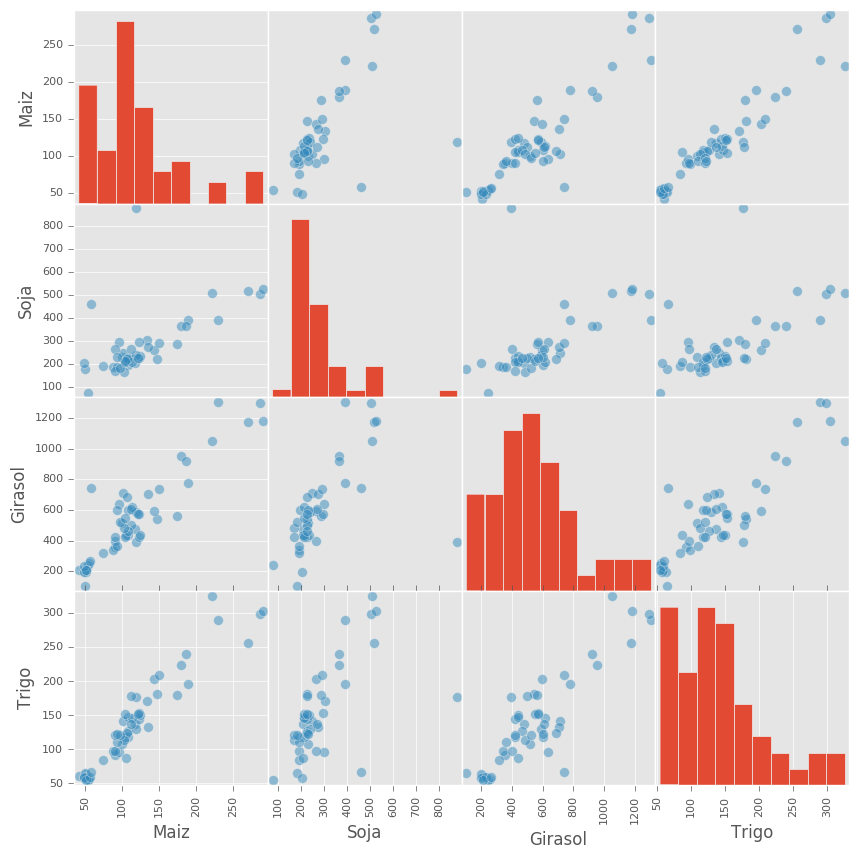

In [53]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df_precios, figsize=(10,10), s=200);

#### Entropia de cultivos vs t ¿Como varió la diversidad de cultivos en el tiempo?

/home/ignacio/github/taller-analisis-datos-101/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


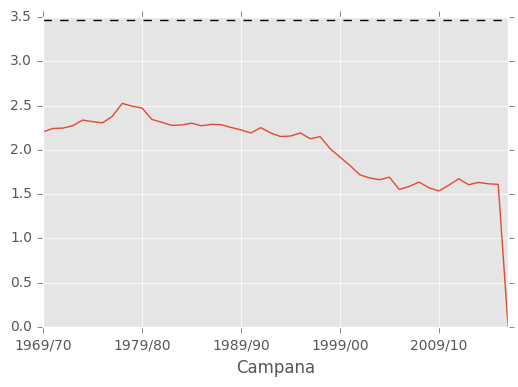

In [54]:
df_all_cult = df_estim.groupby(['Campana', 'Cultivo'])['Sup. Sembrada (Ha)'].sum().reset_index(level=1)
df_all_cult = df_all_cult.pivot(columns='Cultivo', values= 'Sup. Sembrada (Ha)').fillna(0)

p = df_all_cult.div(df_all_cult.sum(axis=1), axis=0)
#df_all_cult / df_all_cult.sum(axis=1)

entropy = (-p*np.log(p)).sum(axis=1)
entropy.plot()

plt.hlines(np.log(p.shape[1]), plt.xlim()[0], plt.xlim()[1], linestyles='--') # MAX ENTROPY


## 3. Mapas

In [55]:
# Plot helper function
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import shapely

def plot_polygon_collection(ax, geoms, values=None, colormap='Set1',  facecolor=None, edgecolor=None,
                            alpha=0.5, linewidth=1.0, **kwargs):
    """ Plot a collection of Polygon geometries """

    patches = []

    for poly in geoms:
        if isinstance(poly, float):
            continue
            
        if poly.geom_type == 'Polygon':
            a = np.asarray(poly.exterior)
            if poly.has_z:
                poly = shapely.geometry.Polygon(zip(*poly.exterior.xy))

            patches.append(Polygon(a))
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                a = np.asarray(subpoly.exterior)
                if subpoly.has_z:
                    subpoly = shapely.geometry.Polygon(zip(*subpoly.exterior.xy))

                patches.append(Polygon(a))

                
    patches = PatchCollection(patches, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, **kwargs)

    if values is not None:
        patches.set_array(values)
        patches.set_cmap(colormap)

    ax.add_collection(patches, autolim=True)
    ax.autoscale_view()
    return ax, patches

In [56]:
# Carga inicial de shapfiles y formas de paises
import geopandas as gpd

gf = gpd.read_file('./data/departamentos/pxdptodatos.shp')
gf  = gf[~gf.nombre.str.contains('Antártida')]
gf = gf[gf.geometry.bounds.maxx < -50] # Sacar islas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [57]:
# Genero un id de departamento en df_estim que sea compatible con el del shapefile
parte1 = df_estim['ID Provincia'].apply(lambda x: '{:02d}'.format(x))
parte2 = df_estim['ID Departamento'].apply(lambda x: '{:03d}'.format(x))
df_estim['link'] = parte1.str.cat(parte2)

### Mapa de % de superficies cultivadas para dos (o mas campanias)

Tarda en correr

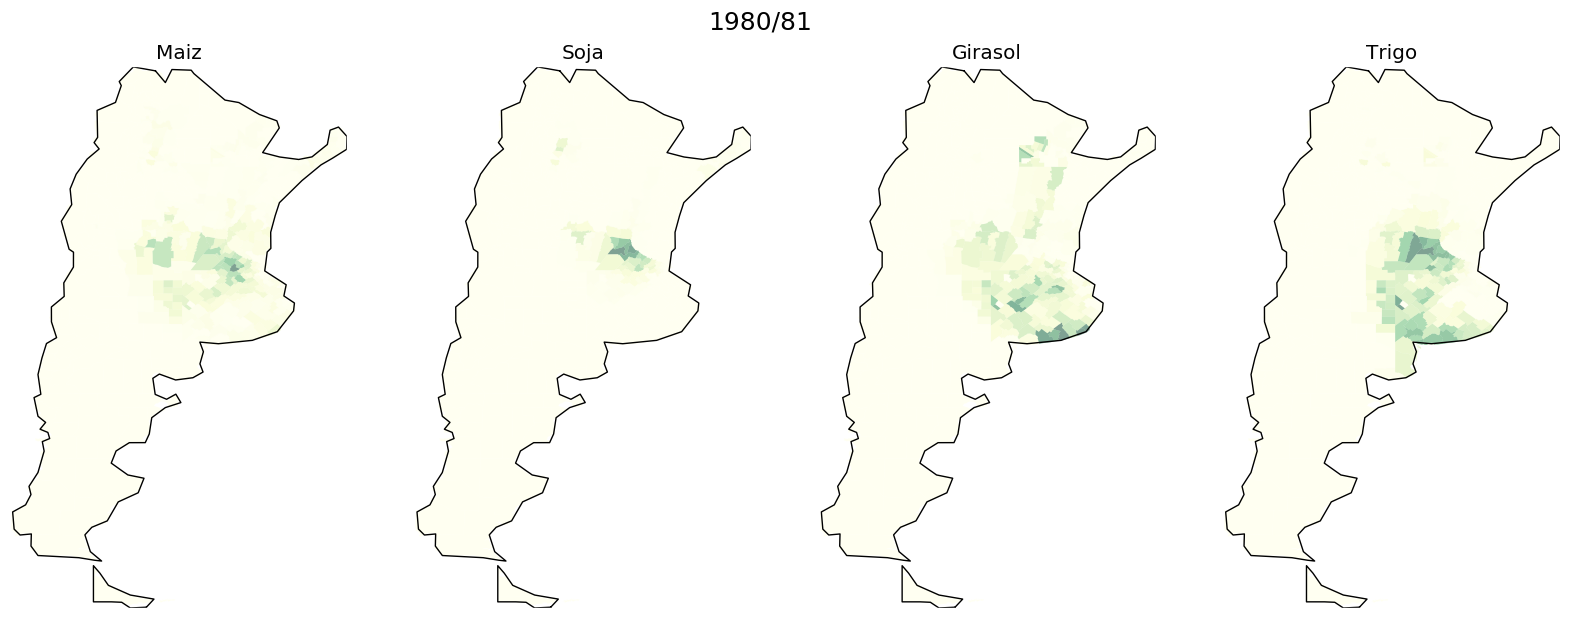

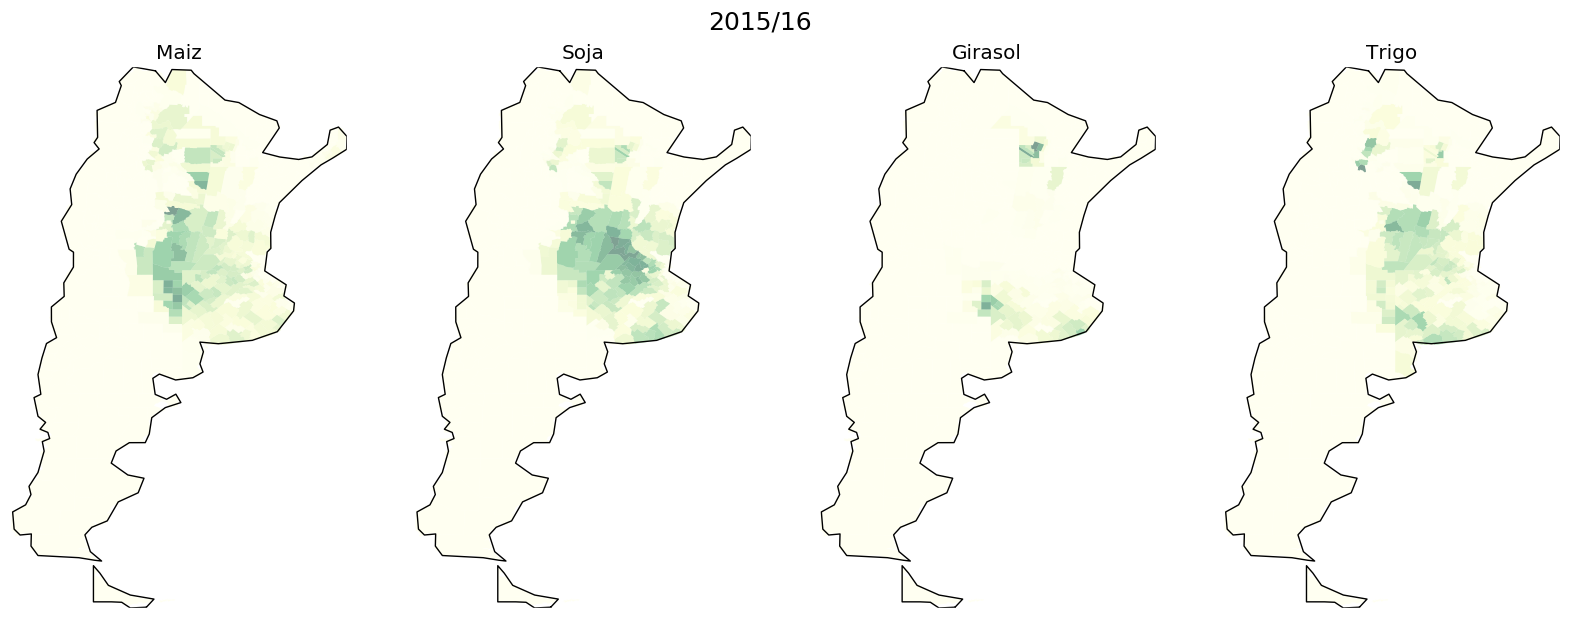

In [58]:
for campana in ['1980/81','2015/16']:
    fig = plt.figure(figsize=(20,7))
    fig.suptitle(campana, fontsize=18)
    for i, cultivo in enumerate(df_ren.columns):
        gf_merge = pd.merge(gf,df_estim[(df_estim.Cultivo==cultivo) & (df_estim.Campana==campana)][['link','Campana','Sup. Sembrada (Ha)']],
                 on='link',how='left')
        gf_merge['Sup. Sembrada (Ha)'].fillna(0, inplace=True)
        gf_merge['porc_sembrado'] = gf_merge['Sup. Sembrada (Ha)']/gf_merge.geometry.area
        ax= fig.add_subplot(1,4,i+1)
        ax.set_axis_bgcolor('white')
        ax.grid('off')
        ax.set_title(cultivo)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        world[world.name=='Argentina'].plot(ax=ax,color='white')
        kw = dict(column='porc_sembrado', k=9, cmap='YlGn', ax=ax, linewidth=0)
        gf_merge.plot(**kw)


### Animacion del cultivo mas sembrado (en sup) en cada depto

In [59]:
# Definir el dataframe del cultivo mas popular por departamento
df_4cult = df_estim[df_estim.Cultivo.isin(df_ren.columns)]
# Un hack porque no me funciona pivot con multiindex
df_4cult.loc[:,'indice'] = df_4cult['Campana'].str.cat(df_4cult['link'], sep=':')
df_4cult = df_4cult.pivot(index='indice',columns='Cultivo', values='Sup. Sembrada (Ha)')
df_4cult = df_4cult.set_index(df_4cult.index.str.split(':', expand=True))
df_4cult['ganador'] = df_4cult.loc[:,df_ren.columns].values.argmin(axis=1)

/home/ignacio/github/taller-analisis-datos-101/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ignacio/github/taller-analisis-datos-101/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


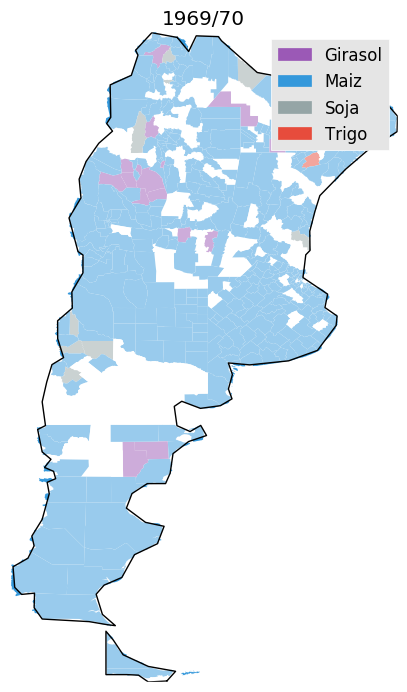

In [60]:
from matplotlib import animation
mis_colores = np.array(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#ffffff"])
legend_handles= []

for i in range(4):
    patch = plt.matplotlib.patches.Patch(color=mis_colores[i], label=df_4cult.columns[i])
    legend_handles.append(patch)

# Create the figure and axis
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'), figsize=(5,10))
plt.legend(handles=legend_handles)
ax.set_axis_bgcolor('white')
ax.grid('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
world[world.name=='Argentina'].plot(ax=ax,color='white')
ax, col = plot_polygon_collection(ax, gf.geometry, linewidth=0, alpha=1)

campanas = df_4cult.index.levels[0]

def init():
    return []


def animate(i):
    ax.set_title(campanas[i])
    gf_winner = pd.merge(gf, df_4cult.loc[campanas[i]].ganador.to_frame(),right_index=True, left_on='link', how='left')
    gf_winner.ganador.fillna(-1, inplace=True)
    col.set_color(mis_colores[gf_winner.ganador.astype(int).values])
    return col,
    

anim = animation.FuncAnimation(fig,animate,frames=len(campanas),interval=500,blit=True)


In [61]:
HTML(anim.to_html5_video())